## Import Semua Packages/ Library yang Digunakan

Mengimpor semua library yang dibutuhkan untuk pemrosesan gambar, augmentasi, pelatihan CNN, dan penyimpanan model.


In [32]:
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from pathlib import Path
import random
from PIL import Image
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, regularizers, models, optimizers
import subprocess


## Data Preparation

Mengunduh dan menyiapkan dataset, kemudian dipindahkan ke struktur direktori:
`/train`, `/val`, dan `/test`.


In [34]:
# Summber dan folder baru 
source_path = Path("dataset")
target_path = Path("dataset_split")

# Daftar kelas
class_names = sorted([cls.name for cls in source_path.iterdir() if cls.is_dir()])
print("Kelas terdeteksi:", class_names)

# Persentase split
split_ratio = (0.8, 0.1, 0.1)

# Fungsi split
def split_and_copy_dataset(source_dir, dest_dir, class_names, split_ratio=(0.8, 0.1, 0.1), seed=42):
    random.seed(seed)
    for cls in class_names:
        img_files = list((source_dir / cls).glob("*"))
        random.shuffle(img_files)

        n_total = len(img_files)
        n_train = int(n_total * split_ratio[0])
        n_val = int(n_total * split_ratio[1])
        n_test = n_total - n_train - n_val

        splits = {
            "train": img_files[:n_train],
            "val": img_files[n_train:n_train + n_val],
            "test": img_files[n_train + n_val:]
        }

        for split_name, file_list in splits.items():
            split_folder = dest_dir / split_name / cls
            split_folder.mkdir(parents=True, exist_ok=True)
            for f in file_list:
                shutil.copy(f, split_folder)

        print(f" {cls} → train: {n_train}, val: {n_val}, test: {n_test}")

# Eksekusi split
split_and_copy_dataset(source_path, target_path, class_names)

Kelas terdeteksi: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
 Cloudy → train: 240, val: 30, test: 30
 Rain → train: 172, val: 21, test: 22
 Shine → train: 202, val: 25, test: 26
 Sunrise → train: 285, val: 35, test: 37


### Data Loading


Total gambar yang berhasil dibaca: 1125


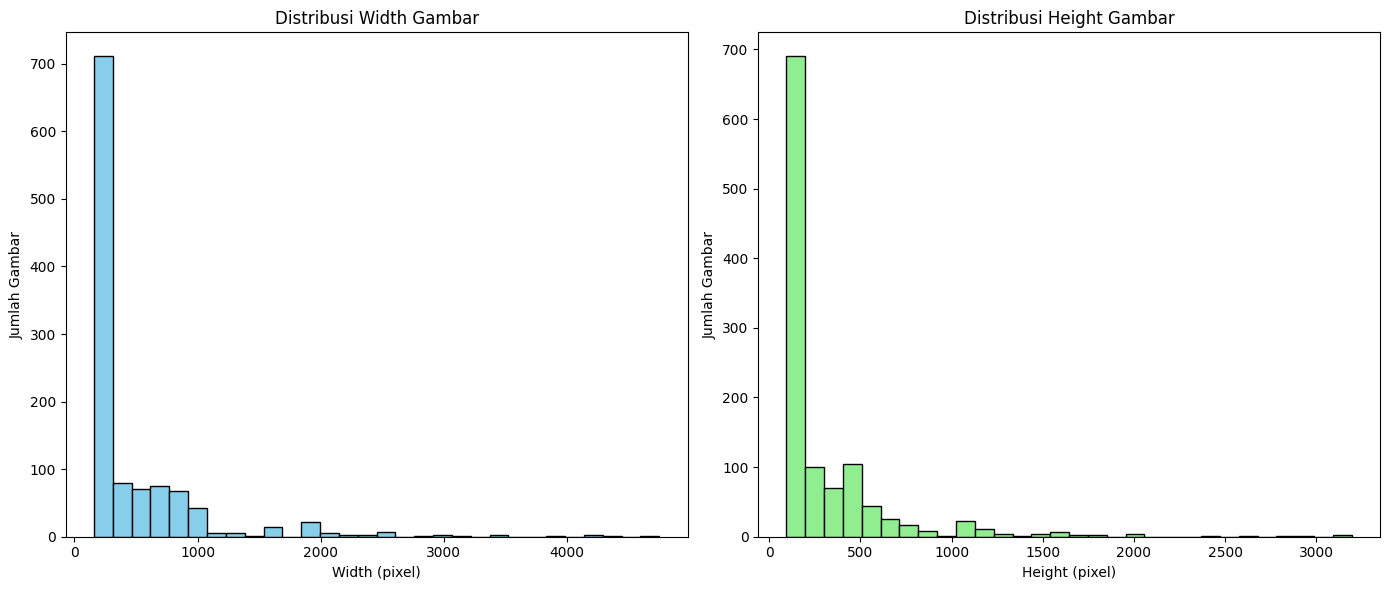

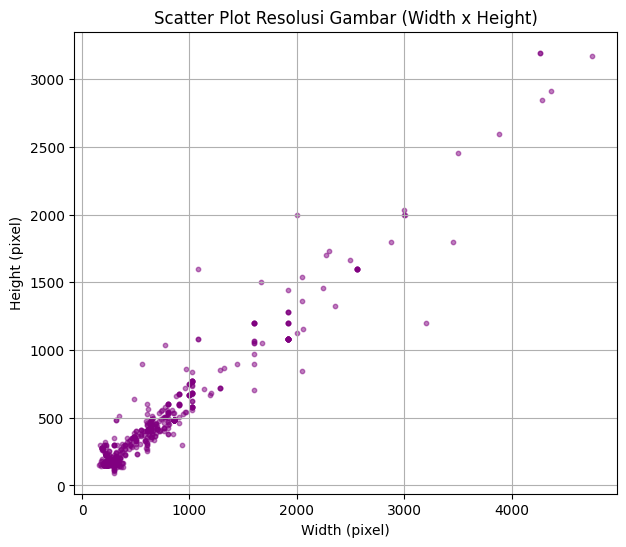

In [36]:
dataset_path = 'dataset'

widths = []
heights = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except Exception as e:
                print(f"Error membuka {img_path}: {e}")

print(f"Total gambar yang berhasil dibaca: {len(widths)}")

plt.figure(figsize=(14, 6))

# Histogram Width
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Width Gambar')
plt.xlabel('Width (pixel)')
plt.ylabel('Jumlah Gambar')

# Histogram Height
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribusi Height Gambar')
plt.xlabel('Height (pixel)')
plt.ylabel('Jumlah Gambar')

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 6))
plt.scatter(widths, heights, alpha=0.5, s=10, c='purple')
plt.title('Scatter Plot Resolusi Gambar (Width x Height)')
plt.xlabel('Width (pixel)')
plt.ylabel('Height (pixel)')
plt.grid(True)
plt.show()


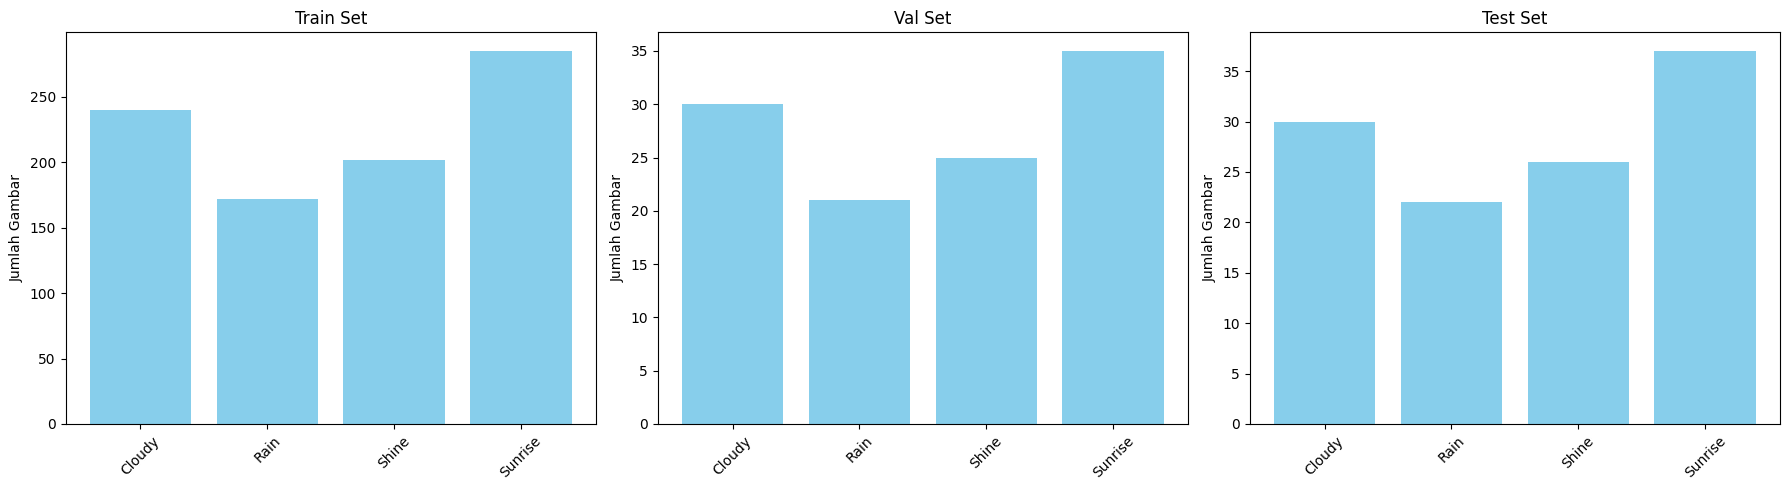

In [37]:
split_path = Path("dataset_split")
splits = ['train', 'val', 'test']

# Hitung jumlah gambar per kelas untuk tiap split
class_counts = {split: {} for split in splits}

for split in splits:
    for cls_folder in (split_path / split).iterdir():
        if cls_folder.is_dir():
            class_counts[split][cls_folder.name] = len(list(cls_folder.glob("*")))

# Visualisasi distribusi kelas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, split in enumerate(splits):
    axes[i].bar(class_counts[split].keys(), class_counts[split].values(), color='skyblue')
    axes[i].set_title(f'{split.capitalize()} Set')
    axes[i].set_ylabel("Jumlah Gambar")
    axes[i].set_xticks(range(len(class_counts[split])))
    axes[i].set_xticklabels(class_counts[split].keys(), rotation=45)
plt.tight_layout()
plt.show()

In [38]:
sample_folder = split_path / 'train'
img_sizes = []

for cls in sample_folder.iterdir():
    if cls.is_dir():
        sample_imgs = list(cls.glob("*"))[:10]  # ambil 10 gambar per kelas
        for img_path in sample_imgs:
            with Image.open(img_path) as img:
                img_sizes.append(img.size)

# Hitung statistik ukuran gambar
widths, heights = zip(*img_sizes)
print("Ukuran gambar (width x height):")
print(f"Min: {min(widths)}x{min(heights)}, Max: {max(widths)}x{max(heights)}")
print(f"Rata-rata: {np.mean(widths):.1f}x{np.mean(heights):.1f}")

Ukuran gambar (width x height):
Min: 225x151, Max: 1920x1080
Rata-rata: 493.8x322.7


In [39]:
extensions = []
for cls in sample_folder.iterdir():
    if cls.is_dir():
        extensions += [img.suffix.lower() for img in cls.glob("*")]

ext_counts = Counter(extensions)
print("Distribusi format file gambar:", dict(ext_counts))

Distribusi format file gambar: {'.jpg': 896, '.jpeg': 3}


### Data Preprocessing

Pada tahap ini, kita akan:
- Mengatur ulang ukuran gambar ke (150x150)
- Menormalisasi pixel ke skala [0, 1]
- Menerapkan augmentasi seperti rotasi, flipping, zoom, dan shifting (hanya untuk data training)
- Membuat generator untuk train, validation, dan test


In [41]:
# Ukuran gambar dan batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Path dataset split
data_split_path = "dataset_split"

# ImageDataGenerator untuk training (dengan augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Untuk validation dan test (tanpa augmentasi)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(data_split_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(data_split_path, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(data_split_path, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 899 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
Found 115 images belonging to 4 classes.


Menampilkan beberapa gambar dari generator training untuk memastikan augmentasi diterapkan dengan benar.


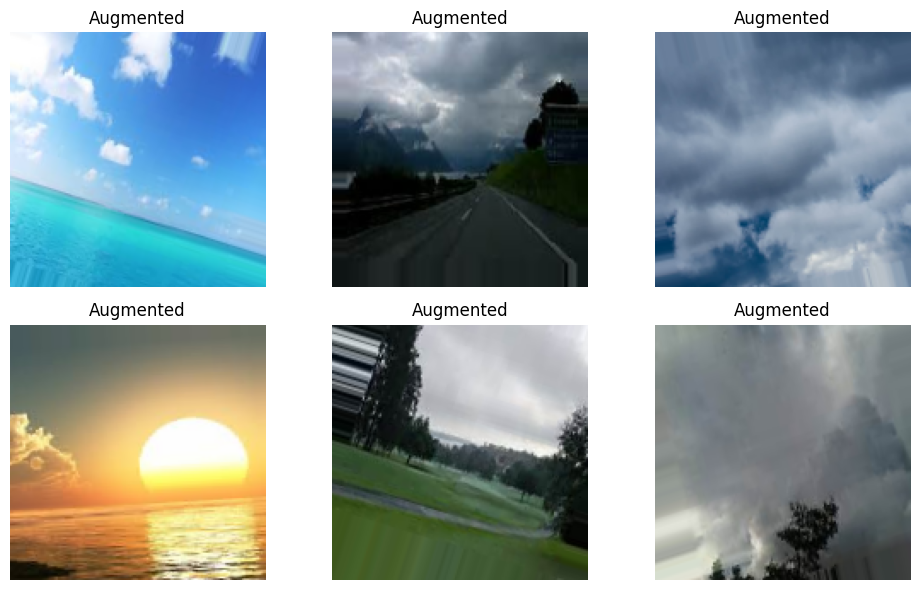

In [43]:
images, labels = next(train_generator)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Augmented")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Modelling

Model CNN dibangun menggunakan `Sequential API` dengan arsitektur:
- 3 blok Conv2D + MaxPooling2D
- Flatten layer
- Dense layer dengan Dropout
- Output layer dengan softmax (4 kelas)

Model juga dilengkapi dengan:
- EarlyStopping untuk menghentikan training saat tidak ada peningkatan
- ModelCheckpoint untuk menyimpan model terbaik


In [45]:
# Jumlah kelas
num_classes = train_generator.num_classes

# Bangun model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [46]:
# Tempat penyimpanan model
checkpoint_path = "saved_model/best_model.keras"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

Model dilatih dengan data training dan divalidasi menggunakan validation set. 
EarlyStopping digunakan untuk menghentikan training jika val_loss tidak membaik dalam 5 epoch. ModelCheckpoint menyimpan model dengan val_accuracy terbaik.


In [48]:
# Training
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/30


2025-06-29 18:20:00.101783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - ETA: 0s - loss: 1.1509 - accuracy: 0.5061  

2025-06-29 18:20:55.745674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.54054, saving model to saved_model/best_model.keras
29/29 [==============================] - 59s 2s/step - loss: 1.1509 - accuracy: 0.5061 - val_loss: 0.7763 - val_accuracy: 0.5405
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.7019  
Epoch 2: val_accuracy improved from 0.54054 to 0.77477, saving model to saved_model/best_model.keras
29/29 [==============================] - 50s 2s/step - loss: 0.7195 - accuracy: 0.7019 - val_loss: 0.5788 - val_accuracy: 0.7748
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.6368 - accuracy: 0.7453 
Epoch 3: val_accuracy improved from 0.77477 to 0.86486, saving model to saved_model/best_model.keras
29/29 [==============================] - 48s 2s/step - loss: 0.6368 - accuracy: 0.7453 - val_loss: 0.4492 - val_accuracy: 0.8649
Epoch 4/30
29/29 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.7775  
Epoch 4: val_accuracy did

## Evaluasi dan Visualisasi

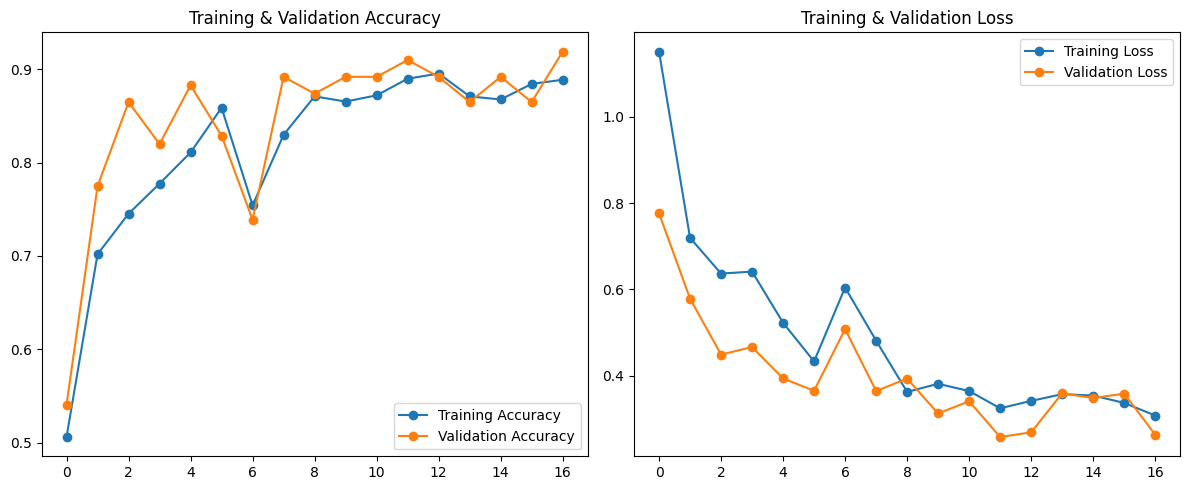

In [50]:
# Visualisasi accuracy dan loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

plt.tight_layout()
plt.show()


In [51]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\n Test Accuracy: {test_accuracy:.4f}")
print(f" Test Loss: {test_loss:.4f}")


2025-06-29 18:34:01.807514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 2s 509ms/step - loss: 0.2433 - accuracy: 0.9217

 Test Accuracy: 0.9217
 Test Loss: 0.2433


2025-06-29 18:34:04.166626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 2s 490ms/step


<Figure size 800x800 with 0 Axes>

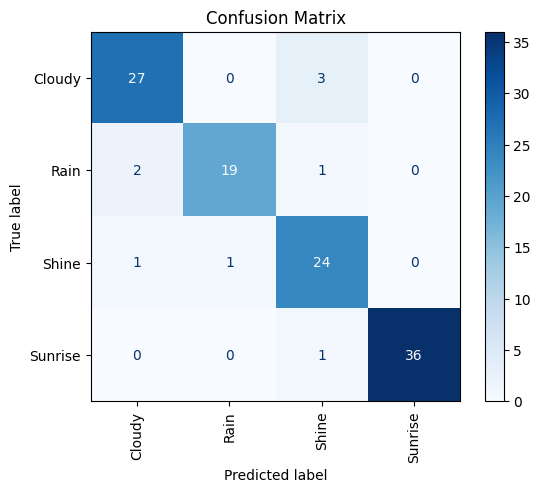


Classification Report:

              precision    recall  f1-score   support

      Cloudy       0.90      0.90      0.90        30
        Rain       0.95      0.86      0.90        22
       Shine       0.83      0.92      0.87        26
     Sunrise       1.00      0.97      0.99        37

    accuracy                           0.92       115
   macro avg       0.92      0.91      0.92       115
weighted avg       0.93      0.92      0.92       115



In [52]:
# Prediksi pada test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Label nama kelas
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

## Konversi Model

In [61]:
saved_model_dir = 'exported_model/saved_model_format'
os.makedirs(saved_model_dir, exist_ok=True)

model.save(saved_model_dir)

print(f" Model berhasil disimpan dalam format SavedModel di: {saved_model_dir}")


2025-06-29 18:47:41.402518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2025-06-29 18:47:41.744286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: exported_model/saved_model_format/assets


INFO:tensorflow:Assets written to: exported_model/saved_model_format/assets


 Model berhasil disimpan dalam format SavedModel di: exported_model/saved_model_format


In [63]:
tflite_model_dir = 'exported_model/tflite'
os.makedirs(tflite_model_dir, exist_ok=True)

# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Simpan model
tflite_model_path = os.path.join(tflite_model_dir, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

class_labels = ['clear', 'cloudy', 'rainy', 'foggy']  # atau sesuai dataset kamu
# Simpan label ke dalam label.txt
labels_path = os.path.join(tflite_model_dir, 'labels.txt')
with open(labels_path, 'w') as f:
    for label in class_labels:
        f.write(label + '\n')

print(f"Label berhasil disimpan di: {labels_path}")


print(f"Model berhasil dikonversi ke TFLite di: {tflite_model_path}")


2025-06-29 18:49:32.715672: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-06-29 18:49:32.715903: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-06-29 18:49:32.718576: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: exported_model/saved_model_format
2025-06-29 18:49:32.720952: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-06-29 18:49:32.721767: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: exported_model/saved_model_format
2025-06-29 18:49:32.735211: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-06-29 18:49:32.854614: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: exported_model/saved_model_format
2025-06-29 18:49:32.880813: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load fo

Label berhasil disimpan di: exported_model/tflite/labels.txt
Model berhasil dikonversi ke TFLite di: exported_model/tflite/model.tflite


In [73]:
command = [
    "tensorflowjs_converter",
    "--input_format=tf_saved_model",         # Format input: model SavedModel
    "--output_format=tfjs_graph_model",      # Format output: Graph model untuk TFJS
    "exported_model/saved_model_format",     # Direktori input SavedModel
    "exported_model/tfjs_model"              # Direktori tujuan output TFJS
]

# Jalankan perintah konversi
result = subprocess.run(command, capture_output=True, text=True)

# Cetak hasil dari proses konversi
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

# Cek apakah konversi berhasil
if result.returncode == 0:
    print("Model berhasil dikonversi ke format TensorFlow.js dan disimpan di 'exported_model/tfjs_model'")
else:
    print("Terjadi kesalahan saat mengonversi model ke TensorFlow.js")
    print("Silakan periksa pesan error di atas (STDERR) untuk detailnya.")

STDOUT:
 
STDERR:
 /Users/macbookair/Downloads/cnn_image_classification/weather-cnn-py310/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version

Model berhasil dikonversi ke format TensorFlow.js dan disimpan di 'exported_model/tfjs_model'


In [79]:
class_indices = train_generator.class_indices
# Urutkan berdasarkan index (bukan nama)
sorted_labels = sorted(class_indices.items(), key=lambda x: x[1])
labels = [label for label, index in sorted_labels]

with open('exported_model/label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')

print("label.txt berhasil disimpan.")


label.txt berhasil disimpan.


## Inference (Optional)

1/1 [==============================] - 0s 119ms/step


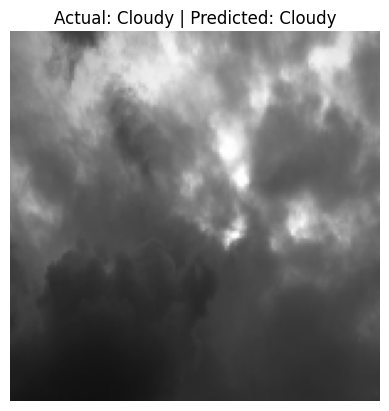

1/1 [==============================] - 0s 29ms/step


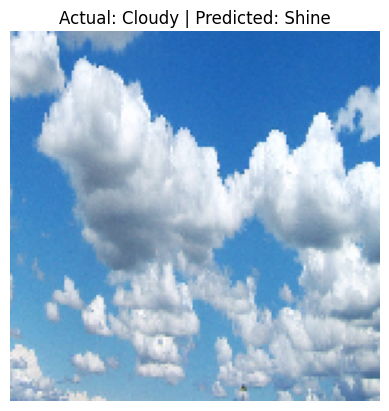

1/1 [==============================] - 0s 27ms/step


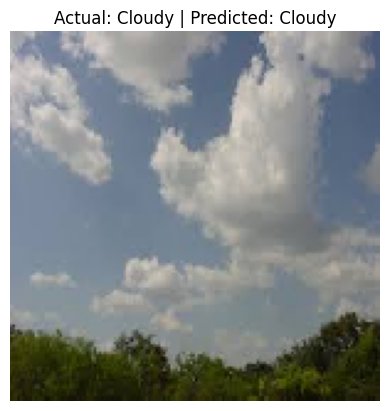

1/1 [==============================] - 0s 46ms/step


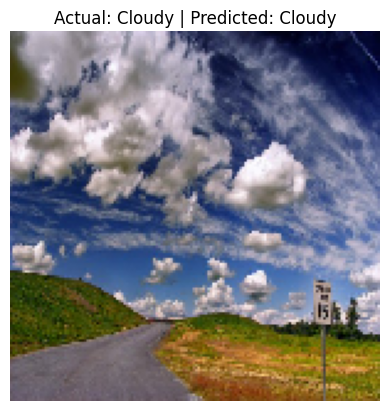

1/1 [==============================] - 0s 30ms/step


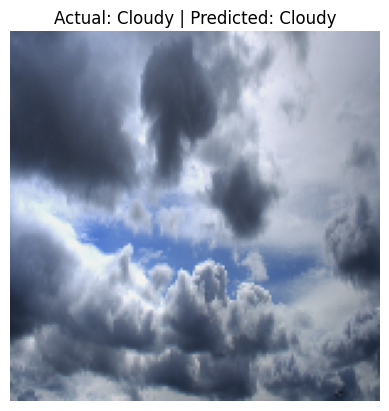

In [71]:
# 5 Contoh gambar
sample_files = test_generator.filepaths[:5]
class_labels = list(test_generator.class_indices.keys())

for img_path in sample_files:
    # Ambil label asli dari nama folder induk
    true_label = os.path.basename(os.path.dirname(img_path))

    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]

    # Plot hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {true_label} | Predicted: {predicted_label}")
    plt.show()
